# 1 Load graph data

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
import warnings; warnings.filterwarnings('ignore')
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [27]:
data = pd.read_csv("../../smiles_list/GLAM-GP/raw/physprop.csv")
# Filter for validated resultsdata_logp = data[data.Status == "Validated"]print("Shape:", data_logp.shape)data_logp.head()

In [28]:
data_logp=data
print("Shape:", data_logp.shape)
data_logp.head()

Shape: (14176, 5)


,Unnamed: 0,SMILES,LogP,LogP rdkit,label
0,1075,Nc1cccc(N)c1,-0.33,0.8510,train
1,7728,CC(C)(SC(=O)N1CCCCC1)c1ccccc1,4.02,4.2608,train
2,8146,CCC(C)c1nnc(N)o1,0.62,1.1653,train
3,11765,CCCCCCCCCC1(c2ccncc2)CCC(=O)NC1=O,4.64,3.8967,train
4,6513,CCNc1nc(NCC)[nH]c(=O)n1,2.29,0.0285,train


In [29]:
molecules = data_logp.SMILES.apply(Chem.MolFromSmiles)
data_logp.loc[:, 'fps'] = molecules.apply(RDKFingerprint)
# data_logp = 

In [30]:
data_logp.head()

,Unnamed: 0,SMILES,LogP,LogP rdkit,label,fps
0,1075,Nc1cccc(N)c1,-0.33,0.8510,train,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,7728,CC(C)(SC(=O)N1CCCCC1)c1ccccc1,4.02,4.2608,train,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
2,8146,CCC(C)c1nnc(N)o1,0.62,1.1653,train,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,11765,CCCCCCCCCC1(c2ccncc2)CCC(=O)NC1=O,4.64,3.8967,train,"[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, ..."
4,6513,CCNc1nc(NCC)[nH]c(=O)n1,2.29,0.0285,train,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


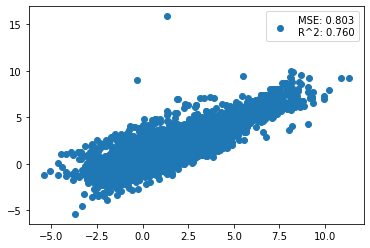

In [63]:
r2 = r2_score(data_logp.LogP, data_logp.loc[:, 'LogP rdkit'])
mse = mean_squared_error(data_logp.LogP, data_logp.loc[:, 'LogP rdkit'])
plt.scatter(data_logp.LogP, data_logp.loc[:, 'LogP rdkit'],
            label = "MSE: {:.3f}\nR^2: {:.3f}".format(mse, r2))
plt.legend()
plt.show()

In [32]:
mse**0.5

0.8959027634491825

# 2. Permute

In [33]:
from tqdm import tqdm
#from crem.crem import perturb_mol
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.DataStructs import FingerprintSimilarity

In [36]:
datapoints={1:[], 2:[], 3:[]} # level 1, 2, 3
simi_lower_uppers = {1:[0.8, 1.0], 2:[0.5,0.8], 3:[0.3, 0.5]}
thre = 0.2

In [38]:
def judge_add_ideal_perturb(smi, logp, fps, smi_perturbed, logp_perturbed, fps_perturbed):
    simi = FingerprintSimilarity(fps, fps_perturbed)
    for level in [1, 2, 3]:
        lower, uppper = simi_lower_uppers[level]
        if lower <= simi < uppper and np.abs(logp_perturbed-logp) < thre:  # abs(x-y) = mae(x, y) = rmse(x, y)
            datapoints[level].append([smi, logp, smi_perturbed, logp_perturbed, simi])

In [ ]:
# 4 hrs
for i in tqdm(range(len(data_logp))):
    item1 = data_logp.iloc[i,:]
    for j in range(len(data_logp)):
        if j==i: continue
        item2 = data_logp.iloc[j,:]
        judge_add_ideal_perturb(item1['SMILES'], item1['LogP'], item1['fps'], item2['SMILES'], item2['LogP'],  item2['fps'])
    print("level1:{}, level2:{}, level3:{}".format(len(datapoints[1]),len(datapoints[2]),len(datapoints[3])))

In [41]:
import torch
# torch.save(datapoints, './datapoints.pt')

# 3. Unique

In [48]:
# datapoints_unique = {1:[], 2:[], 3:[]}
# def unique(level=1):
#     traveled_smiles = []
#     for smi, logp, smi_perturbed, logp_perturbed, simi in datapoints[level]:
#         if smi not in traveled_smiles:
#             traveled_smiles.append(smi)
#             datapoints_unique[level].append([smi, logp, smi_perturbed, logp_perturbed, simi])
# unique(1)
# unique(2)
# unique(3)
# [len(datapoints_unique[i]) for i in [1,2,3]]  # [4240, 9610, 12700]

In [69]:
def unique(datapoints):
    datapoints_unique = {}
    traveled_smiles = []
    _1 = [item[0] for item in datapoints[1]]
    _2 = [item[0] for item in datapoints[2]]
    _3 = [item[0] for item in datapoints[3]]
    for smi, logp, smi_perturbed, logp_perturbed, simi in datapoints[1]:
        if (smi not in traveled_smiles) and (smi in _1) and (smi in _2) and (smi in _3):
            traveled_smiles.append(smi)
            datapoints_unique[smi] = [logp, smi_perturbed, logp_perturbed, simi]
    return datapoints_unique
datapoints_unique = unique(datapoints)

In [70]:
len(datapoints_unique)

3264

In [76]:
def add_perturbed_level23(datapoints_add1):
    all_smiles = datapoints_add1.keys()
    
    datapoints_add2 = {}
    traveled_smiles = []
    for smi, logp, smi_perturbed, logp_perturbed, simi in datapoints[2]:
        if (smi not in traveled_smiles) and (smi in all_smiles):
            traveled_smiles.append(smi)
            item = datapoints_add1[smi]
            datapoints_add2[smi] = item+[smi_perturbed, logp_perturbed, simi]

    datapoints_add3 = {}
    traveled_smiles = []
    for smi, logp, smi_perturbed, logp_perturbed, simi in datapoints[3]:
        if (smi not in traveled_smiles) and (smi in all_smiles):
            traveled_smiles.append(smi)
            item = datapoints_add2[smi]
            datapoints_add3[smi] = item+[smi_perturbed, logp_perturbed, simi]
    
    return datapoints_add3
datapoints_add3 = add_perturbed_level23(datapoints_unique)
len(datapoints_add3)

3264

In [77]:
datapoints_add3['COc1cccc(OC(=O)N(C)C)c1']

[1.6,
 'CCOc1cccc(OC(=O)NC)c1',
 1.75,
 0.8041666666666667,
 'CN(C)C(=O)Oc1ccc([N+](=O)[O-])cc1',
 1.5,
 0.5167173252279635,
 'COc1cccc(OC)c1OC',
 1.53,
 0.39615384615384613]

# 4. Split

In [201]:
from itertools import compress
import numpy as np
from collections import defaultdict
import random
from utils import generate_scaffold
def random_scaffold_split(smiles_list, frac_train=0.8, frac_valid=0.1, frac_test=0.1, seed=0):
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.0)
    non_null = np.ones(len(smiles_list)) == 1
    smiles_list = list(compress(enumerate(smiles_list), non_null))

    rng = np.random.RandomState(seed)

    scaffolds = defaultdict(list)
    for ind, smiles in smiles_list:
        try:
            scaffold = generate_scaffold(smiles, include_chirality=True)
        except:
            continue
        scaffolds[scaffold].append(ind)

    scaffold_sets = rng.perperturb(list(scaffolds.values()))

    n_total_valid = int(np.floor(frac_valid * len(smiles_list)))
    n_total_test = int(np.floor(frac_test * len(smiles_list)))

    train_idx = []
    valid_idx = []
    test_idx = []

    for scaffold_set in scaffold_sets:
        if len(valid_idx) + len(scaffold_set) <= n_total_valid:
            valid_idx.extend(scaffold_set)
        elif len(test_idx) + len(scaffold_set) <= n_total_test:
            test_idx.extend(scaffold_set)
        else:
            train_idx.extend(scaffold_set)

    train_smiles_list = [smiles_list[i][1] for i in train_idx]
    valid_smiles_list = [smiles_list[i][1] for i in valid_idx]
    test_smiles_list = [smiles_list[i][1] for i in test_idx]

    return train_smiles_list, valid_smiles_list, test_smiles_list

In [202]:
# split 3:1:1(:1:1:1)
n_test = int(data_logp.shape[0]*1/6)
_test_rate = n_test/len(datapoints_add3.keys())
_1, _2, test_smi = random_scaffold_split(smiles_list=datapoints_add3.keys(), frac_train=1-_test_rate, frac_valid=0, frac_test=_test_rate)
n_test, len(_1), len(_2), len(test_smi)

(2362, 902, 0, 2362)

In [203]:
test = pd.DataFrame([datapoints_add3[smi] for smi in test_smi])
test.insert(0, 'SMILES', test_smi)
test.insert(0, 'Label', 'test') # ['test']*len(test_smi))
test.columns = ['Label', 'SMILES','LogP', 'SMILES_1','LogP_1','Similrity_1','SMILES_2','LogP_2','Similrity_2', 'SMILES_3','LogP_3','Similrity_3',]

In [204]:
train_val = {}
# remove all datapoint in SMILES, SMILES1, SMILES2, SMILES3
l1, l2, l3, l4 = test['SMILES'].to_list(),test['SMILES_1'].to_list(),test['SMILES_2'].to_list(),test['SMILES_3'].to_list()
for i in range(data_logp.shape[0]):
    smi = str(data_logp.iloc[i, :]['SMILES'])
    if smi not in l1 and smi not in l2 and smi not in l3 and smi not in l4:
        train_val[smi] = data_logp.iloc[i, :].to_list()
len(train_val)

10246

In [214]:
# split 3:1:1(:1:1:1)
train_smi, valid_smi, _ = random_scaffold_split(smiles_list=list(train_val.keys()), frac_train=0.75, frac_valid=0.25, frac_test=0)
len(train_smi), len(valid_smi), len(_)

(7684, 2561, 0)

In [222]:
train = pd.DataFrame([train_val[smi] for smi in train_smi])
train = train.iloc[:, [1,2]]
train.insert(0, 'Label', 'train') # ['test']*len(test_smi))
train.columns = ['Label', 'SMILES','LogP']

In [223]:
valid = pd.DataFrame([train_val[smi] for smi in valid_smi])
valid = valid.iloc[:, [1,2]]
valid.insert(0, 'Label', 'val') # ['test']*len(test_smi))
valid.columns = ['Label', 'SMILES','LogP']

In [224]:
[len(x) for x in [train, valid, test]]

[7684, 2561, 2362]

In [238]:
physprop_perturbed = pd.concat([train, valid, test], keys='Label')

In [239]:
root_path = '../../Dataset/GLAM-GP'
physprop_perturbed.to_csv(root_path+"/raw/physprop_perturb.csv")